In [1]:
import torch 
from transformers import T5Tokenizer
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from enum import Enum
import pandas as pd
import numpy as np
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
class Modes(Enum):
    TRAIN = 1
    VAL = 2
    TEST = 3

In [3]:
ROOT = '/WikiTableQuestions/'
TRAIN_PATH = ROOT + "data/random-split-1-train.tsv"
TEST_PATH = ROOT + "/data/random-split-1-dev.tsv"



class WikiTable(Dataset):
    def __init__(self, mode, tokenizer, img_shape = (400, 1200), 
                 max_len=128, img_format='.png', val_samples = 500):
        assert isinstance(mode, Modes), "Invalid dataset mode given as argument"
        assert val_samples > 1, "Insert a valid number of validation Samples"
        
        self.path = TEST_PATH if mode == Modes.TEST else TRAIN_PATH
        self.mode=mode
        self.format = img_format
        self.val_samples = val_samples
        self.tokenizer = tokenizer
        self.table = self.__setup_table()
        self.max_len = max_len
        self.img_shape = img_shape
    
    def __len__(self):
        return self.table.shape[0]

    
    def __setup_table(self):
        table = None
        #up to the last validation samples
        if self.mode == Modes.TRAIN:
            table = pd.read_csv(self.path, sep='\t')[:-self.val_samples]
        elif self.mode == Modes.VAL:
            #otherwise select the last validation samples
            table = pd.read_csv(self.path, sep='\t')[-self.val_samples:]
        else:
            table = pd.read_csv(self.path, sep='\t')
        
        return table
    
    def __getitem__(self, idx):
        self.table.head()
        sample = self.table.iloc[idx]
        
        question = sample.utterance
        file_path = sample.context.split(".")[0] + self.format
        answer = sample.targetValue
        table_img = Image.open(ROOT+file_path).convert("RGB")
        
        print(table_img)
        display(table_img)
        
        
        input_tokens = self.tokenizer.encode_plus(question,
                                               padding='max_length',
                                               truncation=True,
                                               max_length=self.max_len,
                                               return_tensors='pt')
        
        target_ids = self.tokenizer.encode(answer,
                                           padding='max_length',
                                           truncation=True,
                                           max_length=self.max_len,
                                           return_tensors='pt')
        
        #get augmentations for train, test and validation set
        aug = self.__get_aug()
        if aug is not None:
            table_img = aug(table_img)
            
        return {"table_img": table_img, 
                "question_ids": input_tokens.input_ids.squeeze(),
                "question_attn_mask": input_tokens.attention_mask.squeeze(),
                "question": question,
                "answer": answer,
                "target_ids": target_ids.squeeze()
        }
    
    
    def train_aug(self):
        return transforms.Compose([transforms.Resize(self.img_shape),
                                   transforms.RandomAffine(10),
                                   transforms.ColorJitter(0.3, 0.3, 0.3, 0.4),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                       std=(0.5, 0.5, 0.5)),
                                   ])
        
    def test_aug(self):
        return transforms.Compose([transforms.Resize(self.img_shape),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                       std=(0.5, 0.5, 0.5)),
                                   ])
    
    def __get_aug(self):
        switch = {
            Modes.TRAIN: self.train_aug(),
            Modes.VAL: self.test_aug(),
            Modes.TEST: self.test_aug()
        }
        
        return switch.get(self.mode, None)

<PIL.Image.Image image mode=RGB size=1024x630 at 0x7FF2C10509B0>


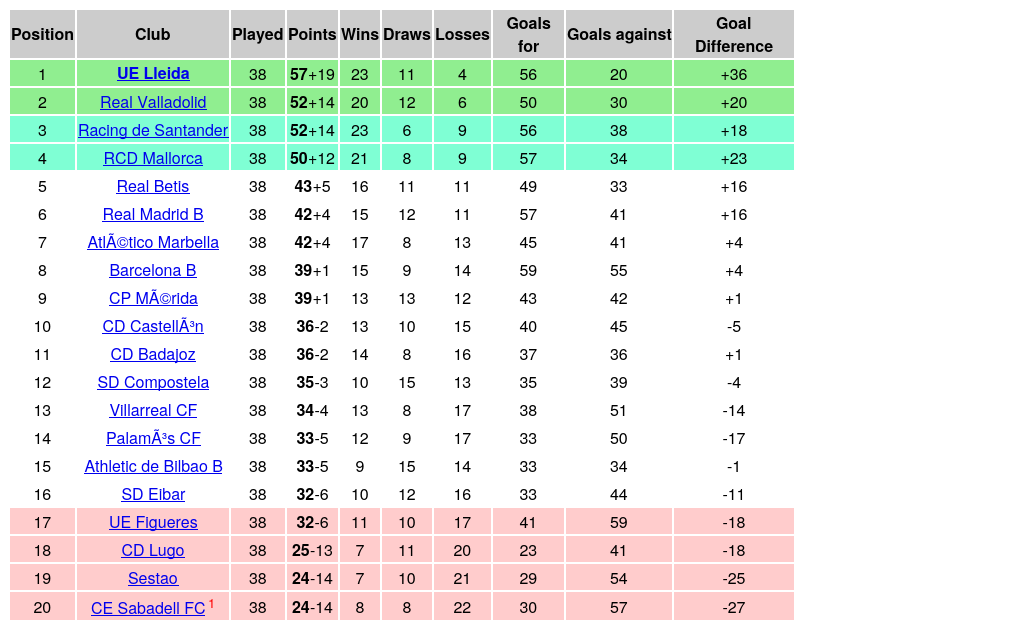

<PIL.Image.Image image mode=RGB size=1024x482 at 0x7FF2C1D58B38>


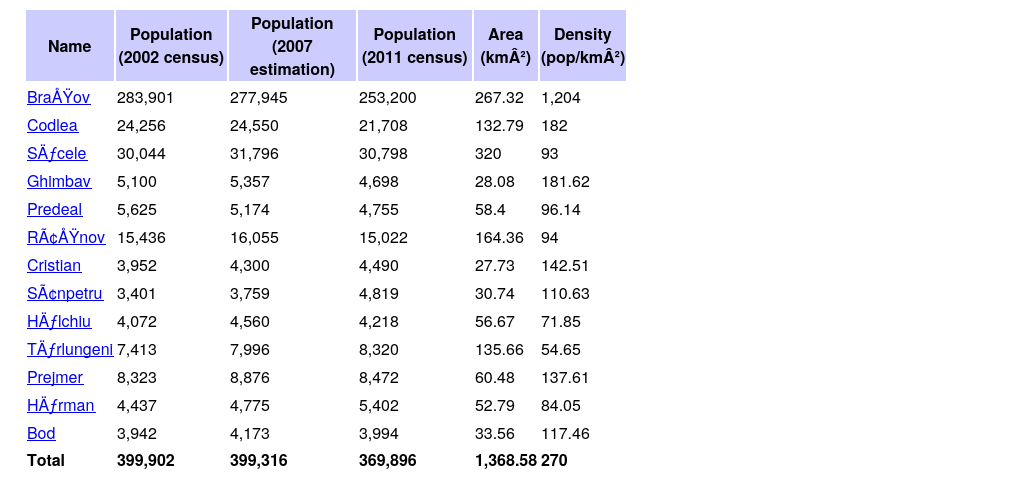

{'table_img': tensor([[[[-0.7412, -0.7412, -0.7412,  ...,  0.9765,  0.9765, -0.7412],
          [-0.7412, -0.7412, -0.7412,  ...,  0.9765,  0.9765, -0.7412],
          [ 0.9765,  0.9765,  0.9765,  ...,  0.9765,  0.9765, -0.7412],
          ...,
          [-0.7412,  0.9765,  0.9765,  ...,  0.9765,  0.9765,  0.9765],
          [-0.7412,  0.9765,  0.9765,  ..., -0.7412, -0.7412, -0.7412],
          [-0.7412,  0.9765,  0.9765,  ..., -0.7412, -0.7412, -0.7412]],

         [[-0.7412, -0.7412, -0.7412,  ...,  0.9765,  0.9765, -0.7412],
          [-0.7412, -0.7412, -0.7412,  ...,  0.9765,  0.9765, -0.7412],
          [ 0.9765,  0.9765,  0.9765,  ...,  0.9765,  0.9765, -0.7412],
          ...,
          [-0.7412,  0.9765,  0.9765,  ...,  0.9765,  0.9765,  0.9765],
          [-0.7412,  0.9765,  0.9765,  ..., -0.7412, -0.7412, -0.7412],
          [-0.7412,  0.9765,  0.9765,  ..., -0.7412, -0.7412, -0.7412]],

         [[-0.7412, -0.7412, -0.7412,  ...,  0.9765,  0.9765, -0.7412],
          [-0.74

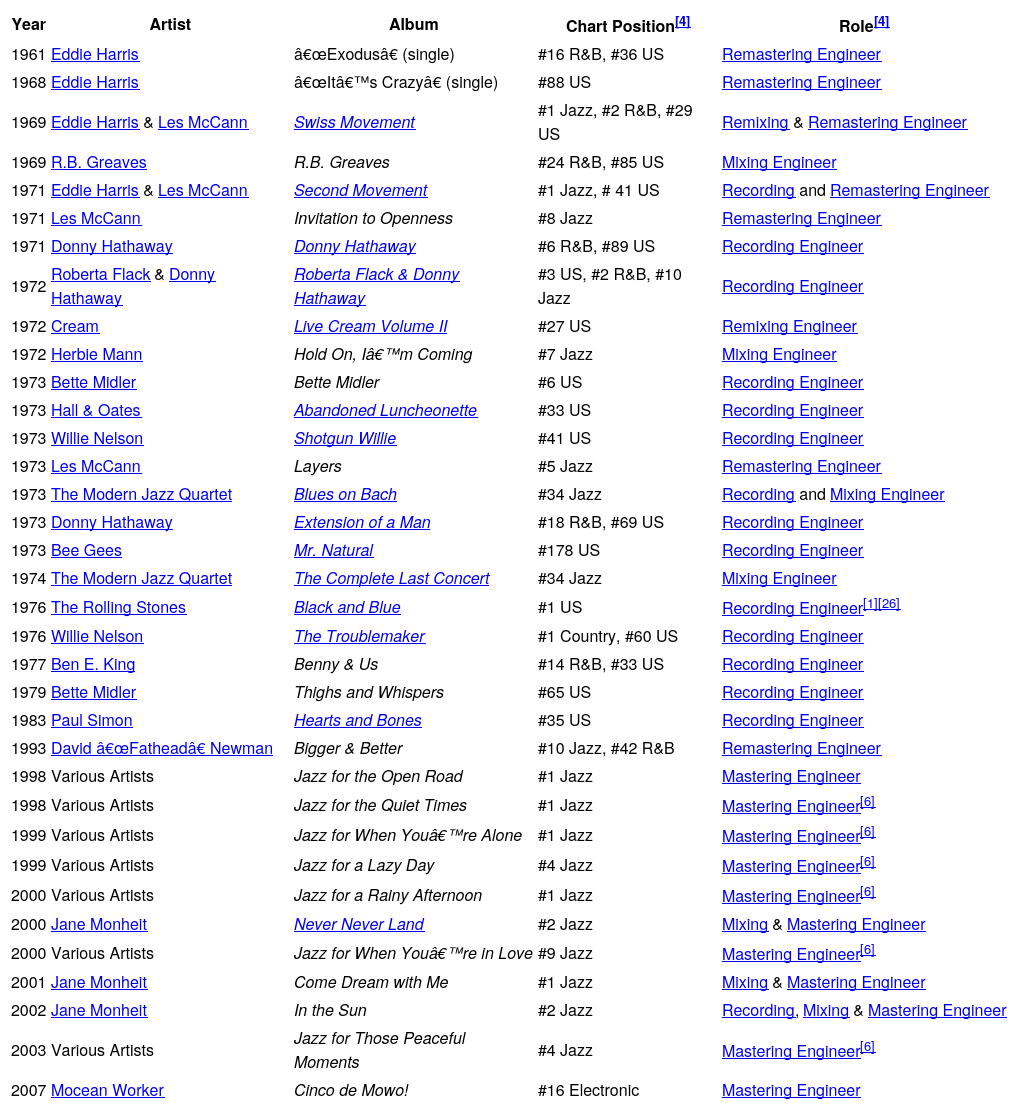

<PIL.Image.Image image mode=RGB size=1024x614 at 0x7FF2CC315E48>


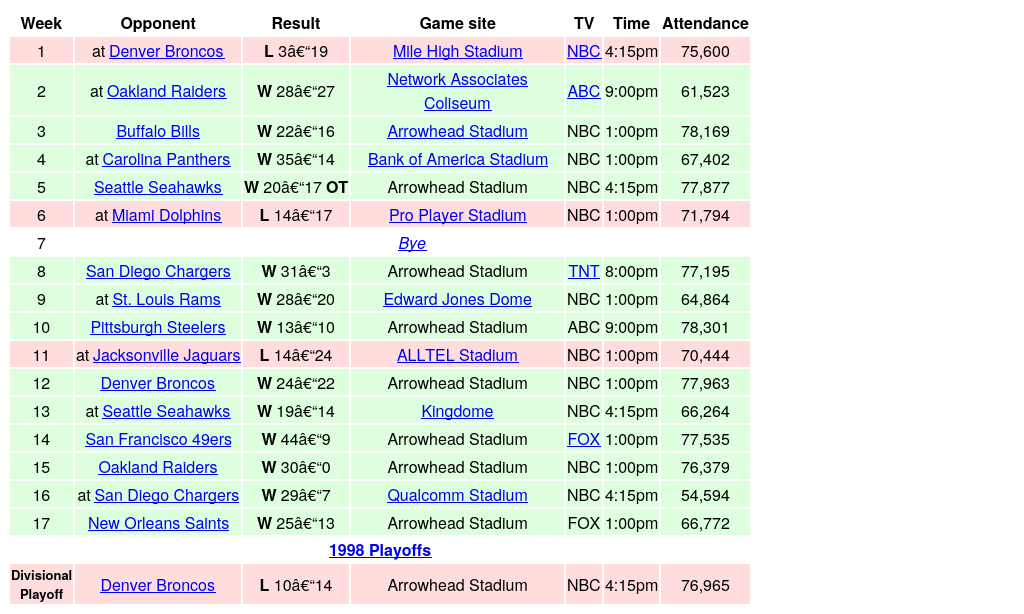

{'table_img': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1.,

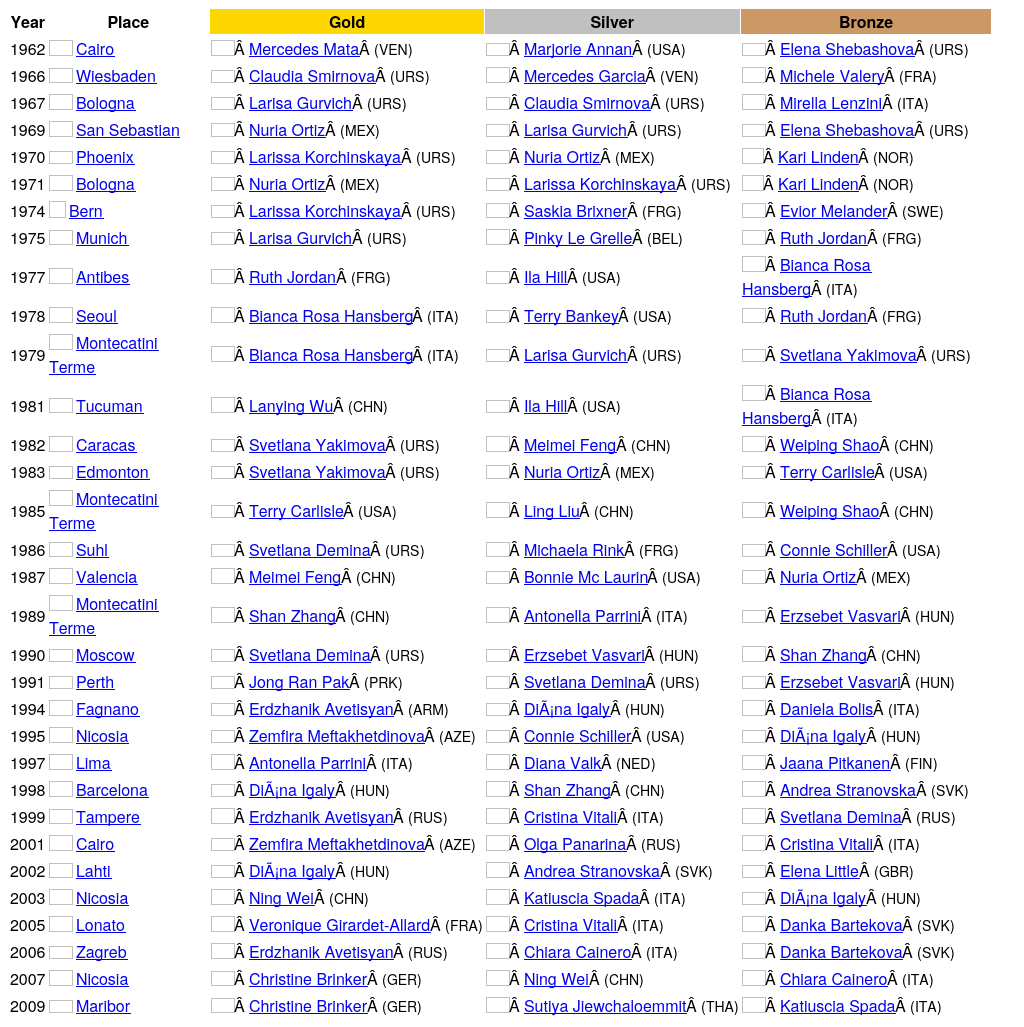

<PIL.Image.Image image mode=RGB size=1024x1050 at 0x7FF2C1D0CEF0>


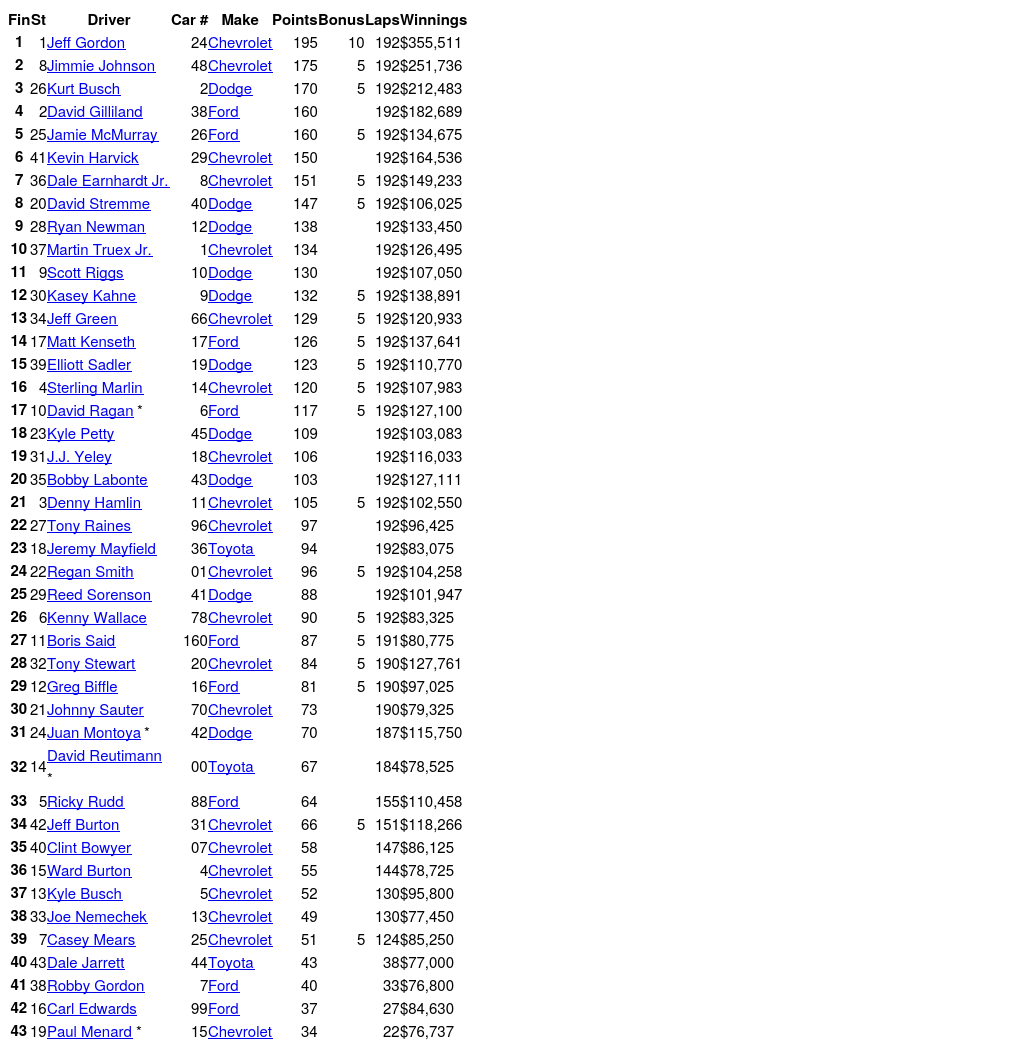

{'table_img': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1.,

In [4]:
if __name__ == "__main__":
    tokenizer = T5Tokenizer.from_pretrained('t5-base')

    wk = WikiTable(Modes.TRAIN, tokenizer=tokenizer)
    ds = DataLoader(wk, batch_size=2, shuffle=True)
    for d in ds:
        print(d)
        break
        
    wk = WikiTable(Modes.VAL, tokenizer=tokenizer)
    
    ds = DataLoader(wk, batch_size=2, shuffle=True)
    for d in ds:
        print(d)
        break
    
    wk = WikiTable(Modes.TEST, tokenizer=tokenizer)
    ds = DataLoader(wk, batch_size=2, shuffle=True)
    for d in ds:
        print(d)
        break